<a href="https://colab.research.google.com/github/Jyothisham/Fish-species-classification-using-MobileNetV2/blob/main/Fish_Species_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings("ignore")

In [2]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset # Download the dataset
!unzip a-large-scale-fish-dataset.zip -d fish_dataset # Extract the zip file to a 'fish_dataset' directory

fish_dir = 'fish_dataset/Fish_Dataset' # Update the path to the extracted dataset
classes = [i for i in os.listdir(fish_dir) if '.' not in i]
classes

Streaming output truncated to the last 5000 lines.
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: 

['Fish_Dataset']

In [3]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label


In [4]:
data.tail()

,path,label
8995,fish_dataset/Fish_Dataset/Fish_Dataset/Hourse ...,Hourse Mackerel
8996,fish_dataset/Fish_Dataset/Fish_Dataset/Hourse ...,Hourse Mackerel
8997,fish_dataset/Fish_Dataset/Fish_Dataset/Hourse ...,Hourse Mackerel
8998,fish_dataset/Fish_Dataset/Fish_Dataset/Hourse ...,Hourse Mackerel
8999,fish_dataset/Fish_Dataset/Fish_Dataset/Hourse ...,Hourse Mackerel


In [5]:
data.head()

,path,label
0,fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp
1,fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp
2,fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp
3,fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp
4,fish_dataset/Fish_Dataset/Fish_Dataset/Shrimp/...,Shrimp


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [7]:
data['label'].value_counts()

,count
label,
Shrimp,1000
Black Sea Sprat,1000
Trout,1000
Red Mullet,1000
Striped Red Mullet,1000
Red Sea Bream,1000
Gilt-Head Bream,1000
Sea Bass,1000
Hourse Mackerel,1000


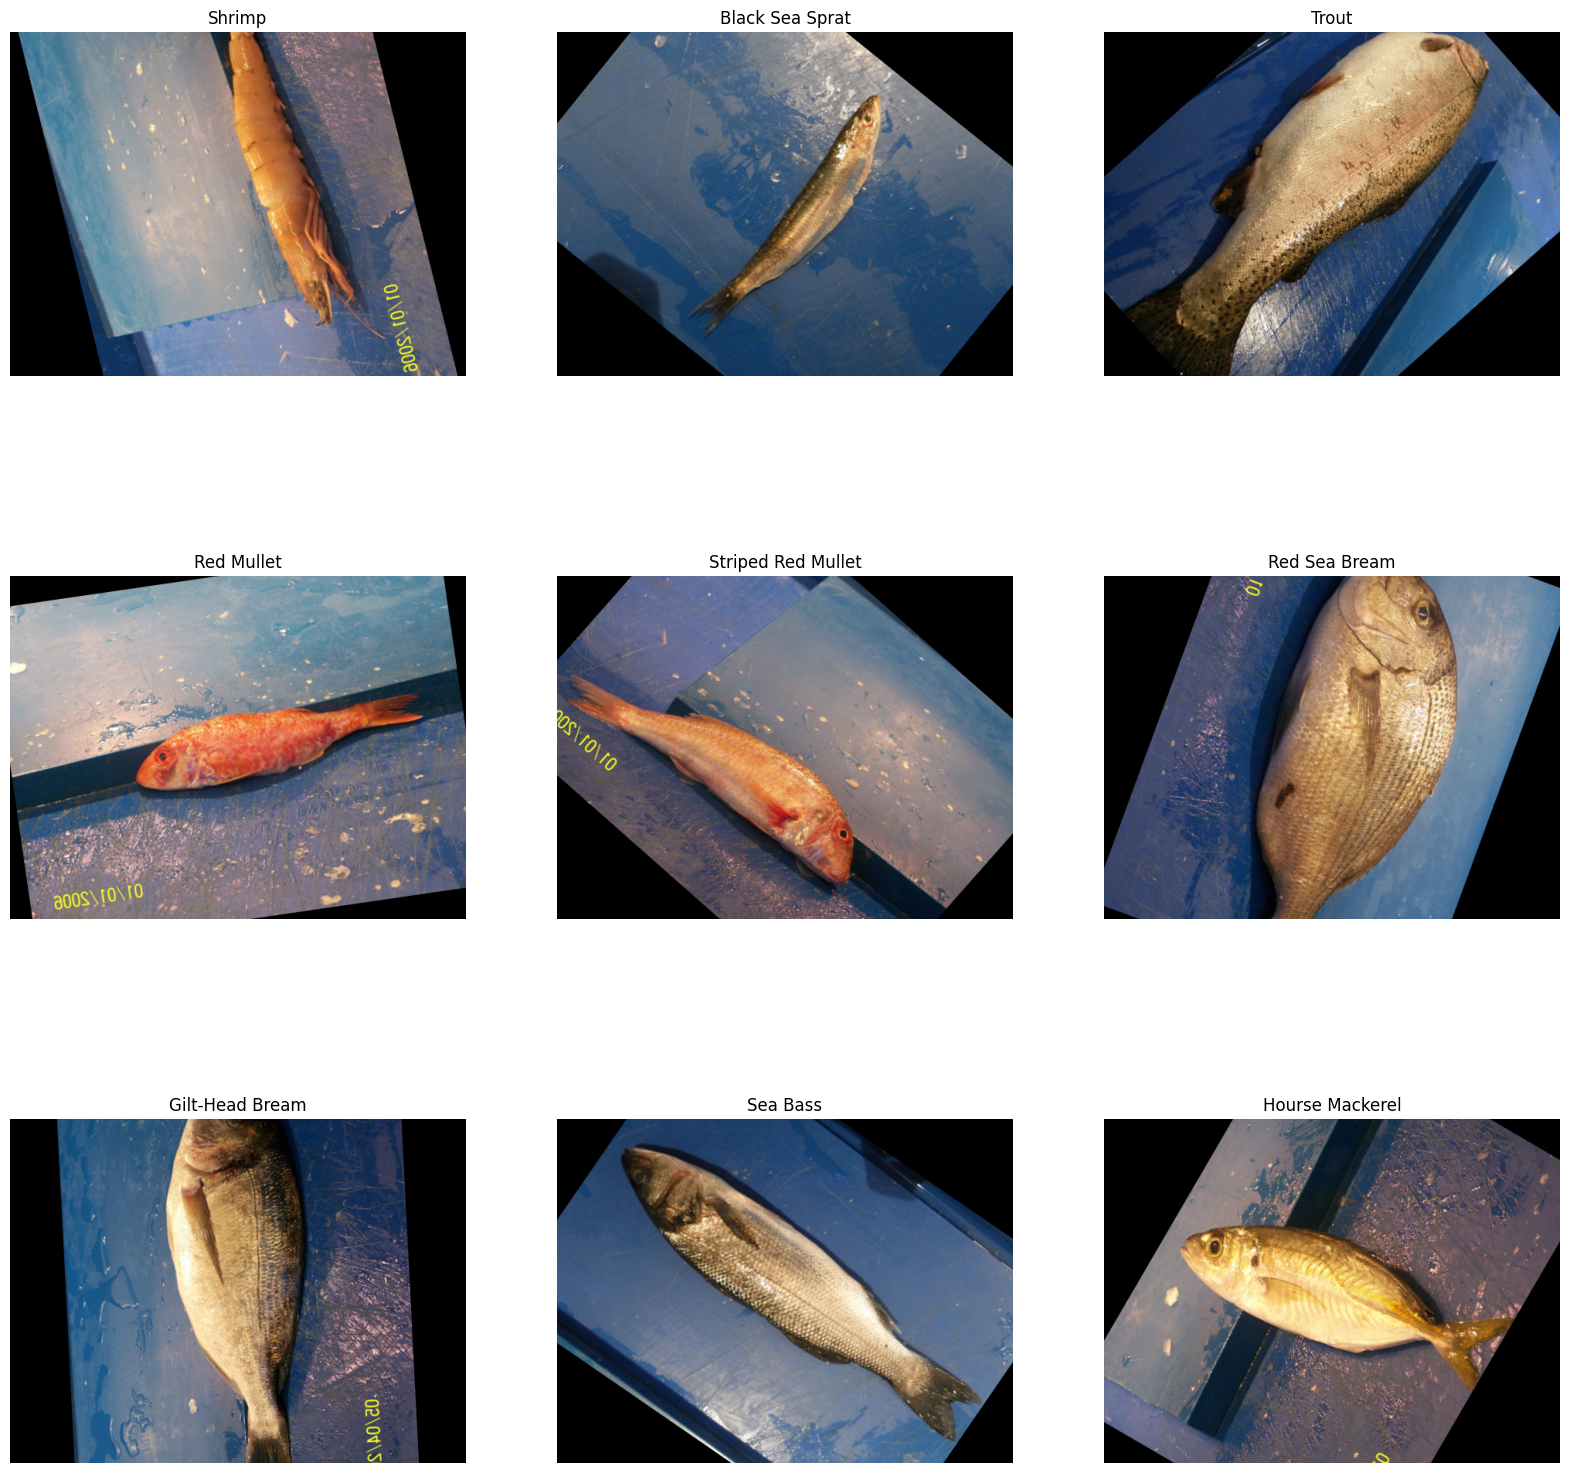

In [8]:
cn = 0
plt.figure(figsize=(20,20))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1

In [9]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [10]:
print(train_data.shape)
print(test_data.shape)

(7200, 2)
(1800, 2)


# Preprocessing and generation

In [11]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [13]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,20))
ax = ax.flatten()

for j in range(6):
    img, label = next(test_images)


    if isinstance(label, (list, np.ndarray)):
        label = label[0]

    if not isinstance(label, str):
        label = str(label)

    ax[j].imshow(img[0])
    ax[j].set_title(label)
    ax[j].axis('off')

plt.tight_layout()
plt.show()

# Model Building

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

In [ ]:
model.evaluate(test_images, verbose=0)

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

In [ ]:
predict_data=test_data.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
predict_data['pred']=pred
predict_data['pred']=predict_data['pred'].apply(lambda x: labels[x])

In [ ]:
predict_data=predict_data.reset_index(drop=True)
predict_data.head(10)
predict_data=predict_data.reset_index(drop=True)
predict_data.head(10)

In [ ]:
predict_data[predict_data['label']!=predict_data['pred']]

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(plt.imread(predict_data.path[1604]))
title1 = predict_data.path[1604].split('/')[-2]
title2 = predict_data.path[1604].split('/')[-1]
title3 = predict_data.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

In [ ]:
print(f"Accuracy Score: {accuracy_score(predict_data['label'],predict_data['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(predict_data['label'],predict_data['pred']), annot=True, fmt='2d')

In [ ]:
print(classification_report(predict_data['label'],predict_data['pred']))